# <a id='toc1_'></a>[2) Cars4You ML Project Price Prediction](#toc0_)
---
**Group 2:**

- Luis Mendes 20221949
- Margarida Mourives 20221809
- Simon Sazonov 20221689 
- Veronica Mendes 20221945

**Group Member Contribution:**
- Luis Mendes:
- Margarida Mourives:
- Simon Sazonov:
- Veronica Mendes:

---



**Table of contents**<a id='toc0_'></a> 
- [Imports](#toc2_)    
- [Data Integration](#toc3_)    
- [Modeling](#toc4_)    
    - [Benchmarking](#toc4_1_1_)    
    - [Random Forest](#toc4_1_2_)    
    - [Final Model](#toc4_1_3_)    
- [Deployment](#toc5_)    
    - [Pipeline Test Set](#toc5_1_1_)    
    - [Prediction](#toc5_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Spliting
from sklearn.model_selection import KFold
# Scaling
from sklearn.preprocessing import RobustScaler
# Imputation
from sklearn.impute import KNNImputer
# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error
# CV Score and Graphing
from utils import avg_scores, graph_actual_vs_predicted

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_context("notebook")
sns.set_style("ticks")

# <a id='toc3_'></a>[Data Integration](#toc0_)

In [2]:
# read data

# for CV
X_CV, y_CV = pd.read_pickle('../project_data/X_Ylog_ModelOptimization.pkl')
X_CV.drop(columns=['Brand'], inplace=True)

# full
X_full, y_full, scaler_full, inputer_full = pd.read_pickle('../project_data/X_Ylog_Scale_Impute_ModelFull.pkl')
X_full.drop(columns=['Brand'], inplace=True)

# for HO
X_train_HO, X_val_HO, y_train_HO, y_val_HO, scaler_HO, inputer_HO = pd.read_pickle('../project_data/Train_Val_Yslog_Scalar_Imputer_ModelHO.pkl')
X_train_HO.drop(columns=['Brand'], inplace=True)
X_val_HO.drop(columns=['Brand'], inplace=True)

# <a id='toc4_'></a>[Modeling](#toc0_)

Now we move on to the modeling phase. Based on the dataset, selected features, and previous analysis, we will first establish a benchmark model using Linear Regression. We will evaluate its MAE on both the training and validation sets using CV. After that, we will build additional models and compare their performance to the benchmark, assessing overfitting and the MAE score on the validation set to determine if they provide any improvement.

At the end of the modeling phase, we will identify the best overall model found and compare its performance to this initial benchmark, as well as comparing all candidate models to one another.

To find the best hyperparameters for the models we are going to test, we will use Grid Search on the Hold-Out (HO) training data. To define the range of parameters to test within the Grid Search , we will first analyze arbitrary values that cause the model to clearly overfit and underfit. We will combine this empirical analysis with 'best practice rules' to establish a robust range. We will then select the parameters that fall in the middle of this range for the final, systematic search.

Subsequently, we will take the best model found and perform the Mean Absolute Error (MAE) evaluation using Cross-Validation (CV) to obtain a more robust final score. We opted for this approach because we want to prioritize testing more models rather than obtaining a more robust solution during the initial Grid Search phase. Since CV takes significantly more time, this approach serves as an efficient time-saver.

Let's start by defining some general parameters, such as the scores for the training and validation sets and Cross-Validation (CV).

In [3]:
dic_train_MAE = {}
dic_val_MAE = {}

method_CV = KFold(n_splits= 6, random_state = 22, shuffle= True)

### <a id='toc4_1_1_'></a>[Benchmarking (Linear Regression)](#toc0_)

We will fit a Linear Regression model and use it as a benchmark. We will evaluate its performance on both the training and validation sets.

In [4]:
avg_scores(X = X_CV,
            y = y_CV,
            CV = method_CV,
            imputer = KNNImputer(n_neighbors=10, weights='uniform'),
            scalar = RobustScaler(),
            model = LinearRegression(),
            score_train_dic = dic_train_MAE,
            score_val_dic = dic_val_MAE,
            dic_key = 'LR-BeanchMark',
            log_transform= True)

6it [06:25, 64.33s/it]


In [5]:
print('CV Results - Linear Regression Benchmark')
print(f'Train MAE: {dic_train_MAE['LR-BeanchMark'][0]}, Train std: {dic_train_MAE['LR-BeanchMark'][1]}')
print(f'Validation MAE: {dic_val_MAE['LR-BeanchMark'][0]}, Validatin std: {dic_val_MAE['LR-BeanchMark'][1]}')

CV Results - Linear Regression Benchmark
Train MAE: 3034.76, Train std: 11.52
Validation MAE: 3034.66, Validatin std: 50.04


The benchmark model achieved a MAE of £3034 on the training set and £3034 on the validation set, showing no signs of overfitting, as the validation score is almost the same as the training score. The standard deviation of the train MAE is £11.52 and for validation, it is £50.04.

Now, we are going to see the graphical difference between the actual and predicted values for the training and testing sets to analyze the model's results.

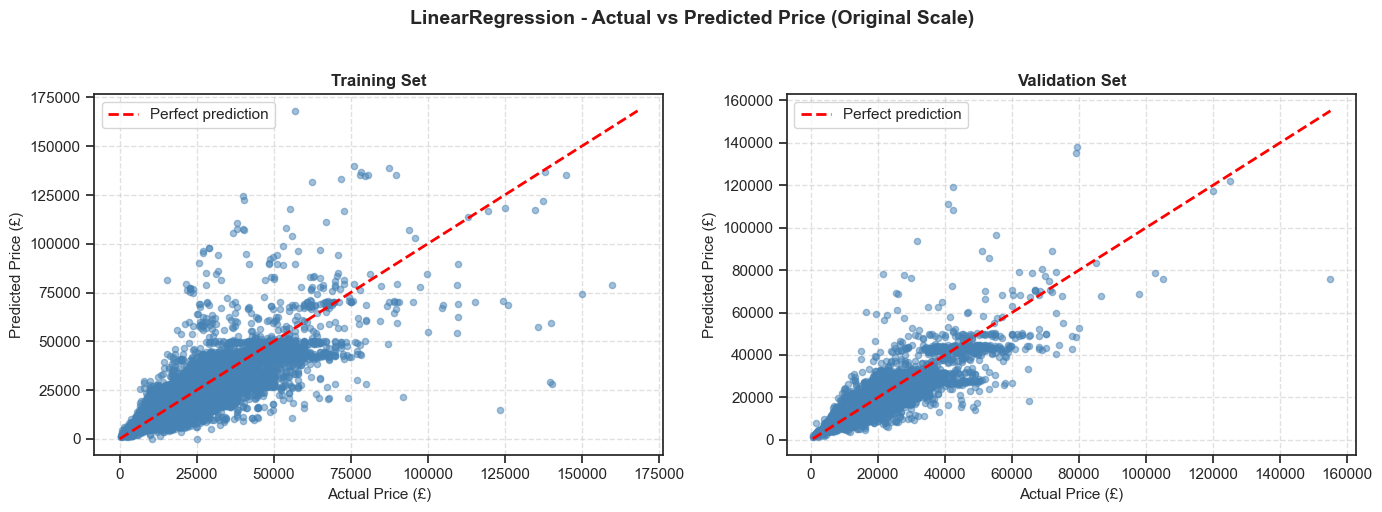

In [4]:
LR_model = LinearRegression()

graph_actual_vs_predicted(LR_model, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

We also see that the model's prediction error starts to increase as the price increases. We will now investigate if other types of models manage to solve this problem.

### KNN

We will test how knn performs


lest analyse on which value of k the model underfits

In [ ]:
# code to underfit

Now lest see on which value it overfits

In [ ]:
# model to overfit

Now lest find the best parameters using grid search

In [ ]:
# code for grid search

In [ ]:
# print the results

we are going to see the score on CV of the bets model found

In [ ]:
# code for CV

In [ ]:
# print of CV results

lest now analyse the actual vs predicted values of that model

In [ ]:
# function for prediction gragh

### <a id='toc4_1_2_'></a>[Random Forest](#toc0_)

In [271]:
RF_model = RandomForestRegressor(random_state=0,
                                criterion='absolute_error',
                                max_features='sqrt',
                                max_depth=10,
                                min_samples_split=10,
                                min_samples_leaf = 5,
                                n_jobs=-1)

RF_model.fit(X_train_imputed, y_train)

print('Train:', mean_absolute_error(y_train, RF_model.predict(X_train_imputed)))
print('Validation:', mean_absolute_error(y_val, RF_model.predict(X_val_imputed)))

Train: 2301.870071670686
Validation: 2361.1593892074197


The Random Forest model achieved a MAE of £2,361 on the validation set, showing a slight overfitting of approximately £61.

### <a id='toc4_1_3_'></a>[Final Model](#toc0_)

The best model was the Random Forest, as it achieved a lower MAE on the validation set (£2,361 vs £3,440 for Linear Regression) while exhibiting only a small amount of overfitting.

Since this model does not require a validation set to control the training process, we will train it on the entire dataset (training + validation) before making predictions on the test set.

In [ ]:
# define imputer, scalar, train on hold out or hole dataset

In [274]:
best_model = RandomForestRegressor(random_state=0,
                                criterion='absolute_error',
                                max_features='sqrt',
                                max_depth=10,
                                min_samples_split=10,
                                min_samples_leaf = 5,
                                n_jobs=-1)
best_model.fit(X_full,y_full)

,n_estimators,100
,criterion,'absolute_error'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# <a id='toc5_'></a>[Deployment](#toc0_)

Let's prepare the test data for predictions. First, we will perform the preprocessing steps one by one, and then create a function that applies all transformations automatically whenever a test dataframe is provided.

### <a id='toc5_1_1_'></a>[Pipeline Test Set](#toc0_)

In [ ]:
def preprocess_and_predict(
    test_df,
    dict_brand_mapping,
    dict_transmission_mapping,
    dict_fuelType_mapping,
    mode_to_fill_transmission,
    mode_to_fill_fueltype,
    train_dummy_columns,
    numerical_cols,
    scaler,
    model,
    imputer,
    filename
):
    # Copy test data
    df_test = test_df.copy()
    df_test.set_index('carID', inplace=True)
    
    # Drop irrelevant columns
    df_test.drop(['paintQuality%', 'hasDamage'], inplace=True, axis=1)
    
    # Correct numeric columns
    df_test['year'] = df_test['year'].round().astype('Int64')
    df_test['mileage'] = pd.to_numeric(df_test['mileage'], errors='coerce').abs()
    df_test['tax'] = pd.to_numeric(df_test['tax'], errors='coerce').abs()
    df_test['mpg'] = pd.to_numeric(df_test['mpg'], errors='coerce').abs()
    df_test['engineSize'] = pd.to_numeric(df_test['engineSize'], errors='coerce').abs()
    df_test.loc[df_test['engineSize'] < 0.9, 'engineSize'] = 0.9
    df_test['previousOwners'] = pd.to_numeric(df_test['previousOwners'], errors='coerce').abs()
    df_test['previousOwners'] = df_test['previousOwners'].round().astype('Int64')
    
    # Clean strings
    df_test = df_test.applymap(lambda x: x.replace(" ", "").lower() if isinstance(x, str) else x)
    
    # Map categorical values
    for key, values in dict_brand_mapping.items():
        df_test.loc[df_test['Brand'].isin(values), 'Brand'] = key
    
    for key, values in dict_transmission_mapping.items():
        df_test.loc[df_test['transmission'].isin(values), 'transmission'] = key if key != 'NAN' else np.nan
    
    for key, values in dict_fuelType_mapping.items():
        df_test.loc[df_test['fuelType'].isin(values), 'fuelType'] = key
    
    # Fill missing categorical values
    df_test['transmission'].fillna(mode_to_fill_transmission, inplace=True)
    df_test['fuelType'].fillna(mode_to_fill_fueltype, inplace=True)
    
    # years old
    
    # Simplify fuelType
    df_test.loc[df_test['fuelType'].isin(['electric', 'hybrid']), 'fuelType'] = 'other'
    
    # Encode categorical variables as dummies
    df_test = pd.get_dummies(df_test, columns=['transmission', 'fuelType'], drop_first=True)
    
    # Add missing dummy columns
    missing_cols = set(train_dummy_columns) - set(df_test.columns)
    for col in missing_cols:
        df_test[col] = 0
    
    # Ensure column order matches training
    df_test = df_test[train_dummy_columns]
    
    # Scale numerical columns
    df_test_num_scaled = scaler.transform(df_test[numerical_cols])
    df_test_num_scaled = pd.DataFrame(df_test_num_scaled, columns=numerical_cols, index=df_test.index)
    
    # Combine scaled numeric and dummy variables
    dummy_cols = [col for col in df_test.columns if col not in numerical_cols]
    df_test_scaled = pd.concat([df_test_num_scaled, df_test[dummy_cols]], axis=1)
    
    # Impute missing values
    df_test_imputed = imputer.transform(df_test_scaled)
    df_test_to_predict = pd.DataFrame(df_test_imputed, columns=df_test_scaled.columns, index=df_test.index)
    
    # Generate predictions
    predictions = model.predict(df_test_to_predict)
    
    # Create predictions DataFrame
    df_predictions = pd.DataFrame({'price': predictions}, index=df_test_to_predict.index)
    
    # Save predictions
    df_predictions.to_csv(f"predictions/{filename}.csv")
    
    return df_predictions

### <a id='toc5_1_2_'></a>[Prediction](#toc0_)

In [ ]:
dict_brand_mapping, dict_transmission_mapping, mode_to_fill_transmission, columns_names_train = pd.read_pickle('../project_data/DicBrand_DicTrans_ModeTrans_ColNames_PrePro.pkl')

In [282]:
df_test = pd.read_csv('../project_data/test.csv')

df_test_predicted = preprocess_and_predict(
    test_df = df_test,
    dict_brand_mapping = dict_brand_mapping,
    dict_transmission_mapping = dict_transmission_mapping,
    dict_fuelType_mapping = dict_fuelType_mapping,
    mode_to_fill_transmission = mode_to_fill_transmission,
    mode_to_fill_fueltype = mode_to_fill_fueltype,
    train_dummy_columns = train_dummy_columns,
    numerical_cols = numerical_cols,
    scaler = scaler,
    model = best_model,
    imputer = inputer,
    filename= 'Group02_Version01'
)

In [283]:
df_test_predicted.head()

,price
carID,
89856,18797.680
106581,22750.630
80886,12483.970
100174,14512.575
81376,26958.055
